In [1]:
"""
Simple tester for the vgg19_trainable
"""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import vgg16_new as vgg16
import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv

PRETRAINED_MODEL_PATH= "/home/sik4hi/ckpt_dir"
N_EPOCHS = 300
INIT_LEARNING_RATE = 0.01
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 90
N_CLASSES = 1000
DROPOUT = 0.50
ckpt_dir = "/home/sik4hi/ckpt_dir"
#LOGS_PATH = '/home/sik4hi/tensorflow_logs'
WEIGHT_PATH = '.npy'
TRAINSET_PATH = '/mnt/data1/imagenet-data/csv-files/train2/imagenetdataall0.csv'
#VALSET_PATH0 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata0.csv'
#VALSET_PATH1 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata1.csv'
#VALSET_PATH2 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata2.csv'
#VALSET_PATH3 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata3.csv'
#VALSET_PATH4 ='/mnt/data1/imagenet-data/csv-files/val/imagenetdata4.csv'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#=======================================================================================================
# Reading Training data from CSV FILE
#=======================================================================================================
f=open(TRAINSET_PATH,"r")
filepaths=[]
labels=[]
for line in f:
    filepath, label= line.split(",")
    label= int(label)
    filepaths.append(filepath)
    labels.append(label)
    
with tf.device('/cpu:0'):
    def _compute_longer_edge(height, width, new_shorter_edge):
        return tf.cast(width*new_shorter_edge/height, tf.int32)

    
    one_ex = tf.train.slice_input_producer([filepaths,labels]
                                           ,capacity = 100000, shuffle=True)
    
    
    im_content = tf.read_file(one_ex[0])
    train_image = tf.image.decode_jpeg(im_content, channels=3)
    
    # train_image = augment(train_image)
    #size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
    #train_image = tf.image.resize_images(train_image, size)
    train_label = tf.cast(one_ex[1], tf.int64) # unnecessary
    
    
    shape = tf.shape(train_image)
    height = shape[0]
    width = shape[1]
    new_shorter_edge = tf.constant(256, dtype=tf.int32)

    height_smaller_than_width = tf.less_equal(height, width)
    new_height_and_width = tf.cond(
        height_smaller_than_width,
        lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
        lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    )
    size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    train_image = tf.image.resize_images(train_image, size)
    size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    train_image = tf.random_crop(train_image, size)
    train_image = tf.image.random_flip_left_right(train_image)
    train_image = tf.cast(train_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
    #train_label_batch = tf.one_hot(train_label_batch, 1000)
    train_image_batch, train_label_batch = tf.train.batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                                  capacity = 1000 + 3*BATCH_SIZE, 
                                                                  num_threads=7)
    #val_csv_path = tf.train.string_input_producer([VALSET_PATH0
    #                                               , VALSET_PATH1,
    #                                               VALSET_PATH2, VALSET_PATH3, 
    #                                               VALSET_PATH4
    #                                              ], shuffle=True)
    #val_textReader = tf.TextLineReader()
    #_, val_content = val_textReader.read(val_csv_path)
    #val_image, val_label = tf.decode_csv(val_content, record_defaults=[[""], [1]])

    #val_image_content = tf.read_file(val_image)
    #val_image = tf.image.decode_jpeg(val_image_content, channels=3)
    

    #shape = tf.shape(val_image)
    #height = shape[0]
    #width = shape[1]
    #new_shorter_edge = tf.constant(256, dtype=tf.int32)
    #height_smaller_than_width = tf.less_equal(height, width)
    #new_height_and_width = tf.cond(
    #    height_smaller_than_width,
    #    lambda: (new_shorter_edge, _compute_longer_edge(height, width, new_shorter_edge)),
    #    lambda: (_compute_longer_edge(width, height, new_shorter_edge), new_shorter_edge)
    #)
    #size = tf.cast([new_height_and_width[0], new_height_and_width[1]], tf.int32)
    #val_image = tf.image.resize_images(val_image, size)
    #size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH, 3], tf.int32)
    #val_image = tf.random_crop(val_image, size)
    #val_image = tf.image.random_flip_left_right(val_image)
    #val_image = tf.cast(val_image, tf.float32) / 255. # necessary


    #val_label = tf.cast(val_label, tf.int64) # unnecessary
    #val_image_batch, val_label_batch = tf.train.shuffle_batch([val_image, val_label], batch_size=BATCH_SIZE,
    #                                                          capacity = 1000 + 3*BATCH_SIZE, 
    #                                                          min_after_dequeue = 1000)

with tf.device('/gpu:0'):
   
    
    
    #images_tf = tf.placeholder(tf.float32, [None, 224, 224, 3])
    #labels_tf = tf.placeholder(tf.int64)
    train_mode = tf.placeholder(tf.bool)

    vgg = vgg16.Vgg16()
    vgg.build(train_image_batch, train_mode=train_mode)
    #weights_only = filter(lambda x: x.name.endswith('W:0'), tf.trainable_variables())
    #for x in xrange(len(weights_only)):
    #    print (weights_only[x].name)
    # print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    #print vgg.get_var_count()


    #==============================================================================================================
    # Defining Loss, could be changed from cross entropy depending on needs. The current configuration works well on
    # multiclass (not hot-encoded vectors) prediction like ImageNET.
    #==============================================================================================================
    with tf.name_scope('Loss'):
        loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(vgg.fc8, train_label_batch), name='loss_tf')
        #loss_summary = tf.summary.scalar("loss", loss_tf)
        #weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables())
        #weight_decay = tf.reduce_mean(tf.add_n([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
        l2_loss=tf.reduce_sum(tf.get_collection("losses"))
        
        loss_tf2 =loss_tf + l2_loss

    # ==============================================================================================================
    # Optimizer, again it can be changed to any function provided by Tensorflow. You can simply use commented out line
    # instead of explicitly computing gradients, if you are not interested in creating summaries of gradients.
    # ==============================================================================================================
    #train_op = tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_tf2)
    train_op = tf.train.AdamOptimizer(learning_rate=0.001,epsilon=0.1).minimize(loss_tf2)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, MOMENTUM)
    #grads_and_vars = optimizer.compute_gradients(loss_tf)
    #grads_and_vars = map(
     #   lambda gv: (gv[0], gv[1]) if ('conv6' in gv[1].name or 'GAP' in gv[1].name) else (gv[0] * 0.1, gv[1]),
      #  grads_and_vars)
    #grads_and_vars = [(tf.clip_by_value(gv[0], -5., 5.), gv[1]) for gv in grads_and_vars]
    #train_op = optimizer.apply_gradients(grads_and_vars)
    #===================================================================================================================
    # Summaries for the gradients
    #===================================================================================================================
    #for var in tf.trainable_variables():
     #   tf.summary.histogram(var.op.name, var)
    #summary_op = tf.summary.merge_all()


    # ===================================================================================================================
    # Accuracy for the current batch
    # ===================================================================================================================
    correct_pred = tf.equal(tf.argmax(vgg.fc8, 1), train_label_batch)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.device('/cpu:0'):    
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    saver = tf.train.Saver(max_to_keep=10)
    
with tf.device('/gpu:0'):
    sess = tf.Session()
    init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
    sess.run(init_op)
    if PRETRAINED_MODEL_PATH:
        print "using Pretrained model"
        ckpt = tf.train.get_checkpoint_state(PRETRAINED_MODEL_PATH)
        print(ckpt)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
    #print(csv_path)
    # For populating queues with batches, very important!
    coord=tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    loss_list, train_list, plot_loss, plot_acc , loss_list2 , val_list ,plot_loss2, plot_acc2, total_loss_list1, total_loss_list2, plot_ttloss, plot_tvloss  = [], [], [], [], [], [], [], [], [], [], [], []
    #summary_writer = tf.summary.FileWriter(LOGS_PATH, graph=tf.get_default_graph())
    steps = 1
    count = 1

    print("finished")

('conv1_1', '2d Value Initialized')
conv1_1_filters_W [3, 3, 3, 64]
('conv1_1', 'L2 Loss Added')
('conv1_1', 'Value Initialized 0')
conv1_1_biases [64]
('conv1_2', '2d Value Initialized')
conv1_2_filters_W [3, 3, 64, 64]
('conv1_2', 'L2 Loss Added')
('conv1_2', 'Value Initialized 0')
conv1_2_biases [64]
('conv2_1', '2d Value Initialized')
conv2_1_filters_W [3, 3, 64, 128]
('conv2_1', 'L2 Loss Added')
('conv2_1', 'Value Initialized 0')
conv2_1_biases [128]
('conv2_2', '2d Value Initialized')
conv2_2_filters_W [3, 3, 128, 128]
('conv2_2', 'L2 Loss Added')
('conv2_2', 'Value Initialized 0')
conv2_2_biases [128]
('conv3_1', '2d Value Initialized')
conv3_1_filters_W [3, 3, 128, 256]
('conv3_1', 'L2 Loss Added')
('conv3_1', 'Value Initialized 0')
conv3_1_biases [256]
('conv3_2', '2d Value Initialized')
conv3_2_filters_W [3, 3, 256, 256]
('conv3_2', 'L2 Loss Added')
('conv3_2', 'Value Initialized 0')
conv3_2_biases [256]
('conv3_3', '2d Value Initialized')
conv3_3_filters_W [3, 3, 256, 256]
(

In [2]:
epoch=50

===========**Training ACCURACY**================
Epoch 55
Training Accuracy:  0.675201
Training Loss: 1.29626
Total Training Loss: 1.42154
Time Elapsed for Epoch:54 is 322.957821886 minutes


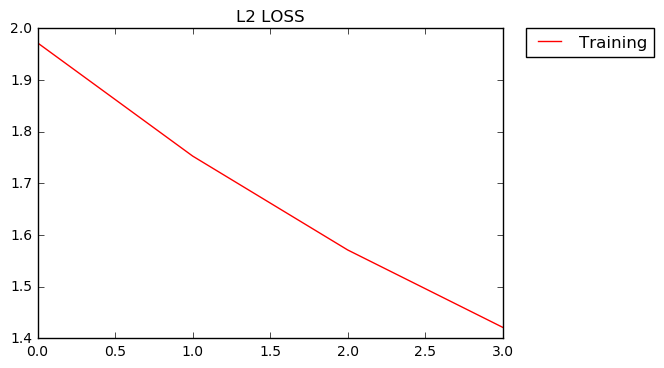

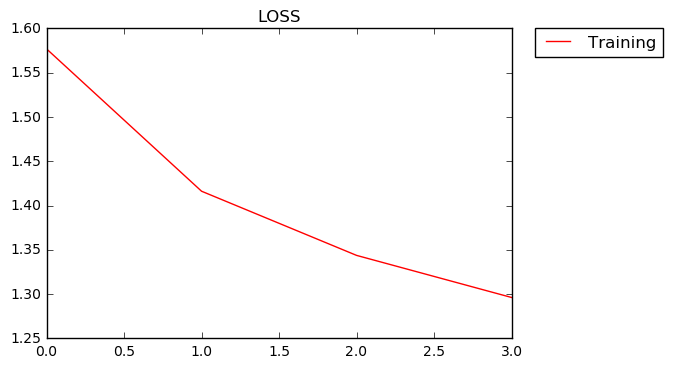

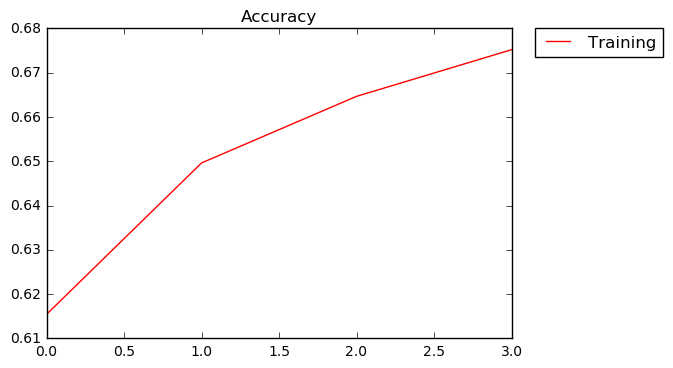

('file saved', '/mnt/data1/imagenet-data/weights/vgg-epoch-54.npy')
14234
Iteration:252  Loss: 1.05148 L2 Loss: 1.35394requesting stop


KeyboardInterrupt: 

In [4]:
try:   
    while not coord.should_stop() and epoch< N_EPOCHS:
        epoch+=1
        epoch_start_time = time.time()
        #iteration_start_time = time.time()
        print((1281144 / BATCH_SIZE))
        #print((2500 / BATCH_SIZE))
        for i in xrange((1281144/ BATCH_SIZE)):
            #train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
            _, train_loss,total_loss, train_accuracy = sess.run(
               [train_op, loss_tf, l2_loss, accuracy],feed_dict={train_mode: True})

            loss_list.append(train_loss)
            train_list.append(train_accuracy)
            total_loss_list1.append(total_loss)
            sys.stdout.write('\r\r' + "Iteration:" + str(i)+ "  Loss: "+ str(train_loss)+ " L2 Loss: "+ str(total_loss))
            sys.stdout.flush()
            #if (i) % 10 == 0:
            #    print ' Time Elapsed for 10 Iterations:' + str(i) + ' is ' + str(
            #        (time.time() - iteration_start_time)) + ' Seconds' 
            #    iteration_start_time = time.time()
            #train_data += len(output_val)
            

        #if (steps) % 5 == 0:  # after 5 batches
        
        tt = np.mean(train_list)
        tl = np.mean(loss_list)
        ttl = np.mean(total_loss_list1)
        
        
        plot_loss.append(tl)
        plot_acc.append(tt)
        plot_ttloss.append(ttl)
      
      
                #summary_writer.add_summary(summary_str, steps)
        loss_list = []
        train_list = []
        total_loss_list1=[]
                
            
        #INIT_LEARNING_RATE *= 0.99

#        for i in xrange((50000 / BATCH_SIZE) ):
#            val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
#            val_accuracy, val_loss, val_tloss = sess.run([accuracy, loss_tf, loss_tf2], feed_dict={images_tf: val_imbatch, labels_tf: val_labatch, train_mode: False})
#            loss_list2.append(val_loss)
#            val_list.append(val_accuracy)
#            total_loss_list2.append(val_tloss)
#            sys.stdout.write('\r' + 'iteration:' + str(i))
#            sys.stdout.flush()
            
#        vt = np.mean(val_list)
#        vl = np.mean(loss_list2)
#        tvl = np.mean(total_loss_list2)
         #f_log.write('epoch:' + str(epoch + 1) + '\tacc:' + str(val_accuracy) + '\n')
        clear_output()
        print "===========**Training ACCURACY**================"
        print "Epoch", epoch + 1#, "Iteration", steps
        #print "Processed", train_data, '/', 7800  # (count*BATCH_SIZE)
        print 'Training Accuracy: ', tt
        #print 'labels: ', train_labatch
        
        print "Training Loss:", tl 
        print "Total Training Loss:", ttl
        
#        print "===========**VALIDATION ACCURACY**================"
#        print 'Epoch:' + str(epoch + 1)# + '\tacc:' + str(val_accuracy) + '\n'
#        print 'Validation Accuracy: ', vt
        #print 'labels: ', train_labatch
#        print "Validation Loss:", vl 
#        print "Total Validation Loss:", tvl
        print 'Time Elapsed for Epoch:' + str(epoch) + ' is ' + str(
            (time.time() - epoch_start_time) / 60.) + ' minutes'
#        plot_loss2.append(vl)
#        plot_acc2.append(vt)
#        plot_tvloss.append(tvl)
        
        plt.figure(1) 
        aa = plt.plot(plot_ttloss,'r',label="Training")
#        bb = plt.plot(plot_tvloss,'g',label="Validation")
        plt.title("L2 LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(2) 
        aa = plt.plot(plot_loss,'r',label="Training")
#        bb = plt.plot(plot_loss2,'g',label="Validation")
        plt.title("LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(3)
        cc = plt.plot(plot_acc,'r',label="Training")
#        dd = plt.plot(plot_acc2,'g',label="Validation")
        plt.title("Accuracy")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
#        loss_list2 = []
#        val_list = []
#        toltal_loss_list2=[]l
        
        saver.save(sess, ckpt_dir + "/model.ckpt", global_step=epoch)
    # test savel
        vgg.save_npy(sess, '/mnt/data1/imagenet-data/weights/vgg-epoch-' + str(epoch) + '.npy')
        ofile  = open('data.csv', "a")
        writer = csv.writer(ofile)
        timep=((time.time() - epoch_start_time) / 60.)
        writer.writerow([tl,ttl,tt,timep,epoch])
        ofile.close()
except tf.errors.OutOfRangeError:
    print ("out of range")
finally:
    coord.request_stop()
    coord.join(threads)
    print("requesting stop")

In [ ]:
for i in xrange((1281144/ BATCH_SIZE)):
    train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
    sys.stdout.write('\r\r'+ str(i))
    sys.stdout.flush()